# **Fine-tuning GPT-2 for Question and answers**


In [ ]:
pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Tokenizer, GPT2LMHeadModel
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:

!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
# downaload dataset from HF
dataset = load_dataset("tau/commonsense_qa")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9741 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1221 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1140 [00:00<?, ? examples/s]

In [ ]:
# inspect dataset
print(dataset.keys())
# print a sample from the dataset
print(dataset['train'][0])

dict_keys(['train', 'validation', 'test'])
{'id': '075e483d21c29a511267ef62bedc0461', 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?', 'question_concept': 'punishing', 'choices': {'label': ['A', 'B', 'C', 'D', 'E'], 'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']}, 'answerKey': 'A'}


In [ ]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
# set padding side to be left because we are doing causal LM
tokenizer.padding_side = "left"

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def massage_input_text(example):
    """
    Helper for converting input examples which have
    a separate question, labels, answer options
    into a single string.

    Arguments
    ---------
    example: dict
        Sample input from the dataset which contains the
        question, answer labels (e.g. A, B, C, D),
        the answer options for the question, and which
        of the answers is correct.

    Returns
    -------
    input_text: str
        Formatted training text which contains the question,
        the formatted answer options (e.g., 'A. <option 1> B. <option 2>' etc)
        and the ground truth answer.
    """
    # combine each label with its corresponding text
    answer_options_list = list(zip(
        example["choices"]["label"],
        example["choices"]["text"]
    ))
    # join each label and text with '. ' and space
    answer_options = " ".join([f"{label}. {text}" for label, text in answer_options_list])
    # join the list of options with spaces into a single string
    answer_options_string = " ".join(answer_options.split())
    # combine question and answer options
    input_text = example["question"] + " " + answer_options_string
    # append the true answer with a new line, "Answer: " and the label
    input_text += "\nAnswer: " + example["answerKey"]

    return input_text

# Process input texts of train and test sets
massaged_datasets = dataset.map(
    lambda example: {
        "text": massage_input_text(example)
    }
)


Map:   0%|          | 0/9741 [00:00<?, ? examples/s]

Map:   0%|          | 0/1221 [00:00<?, ? examples/s]

Map:   0%|          | 0/1140 [00:00<?, ? examples/s]

In [ ]:
# inspect a sample from our preprocessed data
massaged_datasets["train"][0]
# massaged_datasets.column_names

{'id': '075e483d21c29a511267ef62bedc0461',
 'question': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change?',
 'question_concept': 'punishing',
 'choices': {'label': ['A', 'B', 'C', 'D', 'E'],
  'text': ['ignore', 'enforce', 'authoritarian', 'yell at', 'avoid']},
 'answerKey': 'A',
 'text': 'The sanctions against the school were a punishing blow, and they seemed to what the efforts the school had made to change? A. ignore B. enforce C. authoritarian D. yell at E. avoid\nAnswer: A'}

In [ ]:
class CommonsenseQADataset(Dataset):
    """
    Custom dataset class for CommonsenseQA dataset.
    """

    def __init__(
            self,
            train_split,
            test_split,
            tokenizer,
            max_length=64,
            dataset_split="train",
        ) -> None:
        """
        Initialize the dataset object.

        Arguments
        ---------
        train_split: dict
            Training data dictionary with different columns.
        test_split: dict
            Test data dictionary with different columns.
        tokenizer: Tokenizer
            Initialized tokenizer for processing samples.
        max_length: int
            Maximal length of inputs. All inputs will be
            truncated or padded to this length.
        dataset_split: str
            Specifies which split of the dataset to use.
            Default is "train".
        """
        self.train_split = train_split['text']
        self.test_split = test_split['text']
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.dataset_split = dataset_split

    def __len__(self):
        """
        Method returning the length of the training dataset.
        """
        if self.dataset_split == "train":
            return len(self.train_split)
        elif self.dataset_split == "test":
            return len(self.test_split)

    def __getitem__(self, idx):
        # Retrieve a training sample at the specified index idx
        # HINT: Note that this might depend on self.dataset_split
        if self.dataset_split == "train":
            input_text = self.train_split[idx]
        elif self.dataset_split == "test":
            input_text = self.test_split[idx]

        tokenized_input = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        tokenized_input["attention_mask"] = (tokenized_input["input_ids"].squeeze(0) != self.tokenizer.pad_token_id).long()
        return tokenized_input


In [ ]:
# move to accelerated device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Device: {device}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Device: {device}")
else:
    device = torch.device("cpu")
    print(f"Device: {device}")


Device: cuda


In [ ]:
# Load pretrained GPT-2 model from Hugging Face
model = AutoModelForCausalLM.from_pretrained("gpt2")
# Print number of trainable parameters
model_size = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT-2 size: 124.4M parameters


Hint: If you run out of memory while trying to run the training, try decreasing the batch size.

In [ ]:
# Instantiate dataset with the downloaded commonsense_qa data
train_dataset = CommonsenseQADataset(
    train_split=massaged_datasets["train"],
    test_split=massaged_datasets["test"],
    tokenizer=tokenizer
)

# Instantiate test dataset with the downloaded commonsense_qa data
test_dataset = CommonsenseQADataset(
    train_split=massaged_datasets["train"],
    test_split=massaged_datasets["test"],
    tokenizer=tokenizer,
    dataset_split="test"
)

# Create a DataLoader for the dataset
# The data loader will automatically batch the data
# and iteratively return training examples (question answer pairs) in batches
dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

# Create a DataLoader for the test dataset
# Reason for separate data loader is that we want to
# be able to use a different index for retrieving the test batches
# We might also want to use a different batch size etc.
test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True
)


In [ ]:
# Put the model in training mode
model.train()


# Move the model to the device (e.g. GPU)
model = model.to(device)

# Training configurations
epochs = 1
train_steps = len(train_dataset) // 32
# train_steps=1
print("Number of training steps: ", train_steps)

# Number of test steps to perform every 10 training steps
# (smaller than the entire test split for reasons of computational time)
num_test_steps = 5

# Define optimizer and learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

# Define some variables to accumulate the losses
losses = []
test_losses = []

# Iterate over epochs
for e in range(epochs):
    # Iterate over training steps
    for i in tqdm(range(train_steps)):
        # Get a batch of data
        x = next(iter(dataloader))
        # Move the data to the device (GPU)
        x = {key: value.to(device) for key, value in x.items()}

        # Forward pass through the model
        # outputs = model(**x)
        # forward pass through the model

        outputs = model(input_ids=x["input_ids"], attention_mask=x["attention_mask"], labels=x["input_ids"])
        optimizer.zero_grad()  # Clear gradients
        # # Get the loss
        loss = outputs.loss
        print(loss)
        # Backward pass

        # optimizer.step()
        loss.backward()  # Compute gradients
        # optimizer.step()  # Update model parameters

        losses.append(loss.item())

        # Evaluate on test set every 10 steps
        if i % 10 == 0:
            print(f"Epoch {e}, step {i}, loss {loss.item()}")
            # Track test loss for the evaluation iteration
            test_loss = 0
            for j in range(num_test_steps):
            #     # Get test batch
                x_test = next(iter(test_dataloader))
                x_test = {key: value.to(device) for key, value in x_test.items()}
                with torch.no_grad():
                    # test_outputs = model(**x_test)
                     test_outputs = model(input_ids=x["input_ids"], attention_mask=x["attention_mask"], labels=x["input_ids"])

                test_loss += test_outputs.loss.item()

            test_losses.append(test_loss / num_test_steps)
            print("Test loss: ", test_loss / num_test_steps)


Number of training steps:  304


  0%|          | 0/304 [00:00<?, ?it/s]

tensor(8.1474, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 0, loss 8.147440910339355


  0%|          | 1/304 [00:03<18:38,  3.69s/it]

Test loss:  8.302724647521973
tensor(8.5035, device='cuda:0', grad_fn=<NllLossBackward0>)


  1%|          | 2/304 [00:04<09:03,  1.80s/it]

tensor(8.2248, device='cuda:0', grad_fn=<NllLossBackward0>)


  1%|          | 3/304 [00:04<06:01,  1.20s/it]

tensor(8.3715, device='cuda:0', grad_fn=<NllLossBackward0>)


  1%|▏         | 4/304 [00:05<04:37,  1.08it/s]

tensor(8.1406, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 5/304 [00:05<03:48,  1.31it/s]

tensor(8.1674, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 6/304 [00:06<03:18,  1.50it/s]

tensor(8.1358, device='cuda:0', grad_fn=<NllLossBackward0>)


  2%|▏         | 7/304 [00:06<02:59,  1.65it/s]

tensor(8.1604, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 8/304 [00:07<02:46,  1.77it/s]

tensor(8.0269, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 9/304 [00:07<02:38,  1.86it/s]

tensor(8.3769, device='cuda:0', grad_fn=<NllLossBackward0>)


  3%|▎         | 10/304 [00:08<02:32,  1.92it/s]

tensor(8.2853, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 10, loss 8.285304069519043


  4%|▎         | 11/304 [00:09<03:53,  1.26it/s]

Test loss:  8.205036163330078
tensor(8.2571, device='cuda:0', grad_fn=<NllLossBackward0>)


  4%|▍         | 12/304 [00:09<03:26,  1.42it/s]

tensor(8.2658, device='cuda:0', grad_fn=<NllLossBackward0>)


  4%|▍         | 13/304 [00:10<03:07,  1.56it/s]

tensor(8.4407, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▍         | 14/304 [00:10<02:56,  1.65it/s]

tensor(8.3529, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▍         | 15/304 [00:11<02:46,  1.73it/s]

tensor(7.9675, device='cuda:0', grad_fn=<NllLossBackward0>)


  5%|▌         | 16/304 [00:12<02:42,  1.77it/s]

tensor(8.1436, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▌         | 17/304 [00:12<02:41,  1.78it/s]

tensor(8.4058, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▌         | 18/304 [00:13<02:36,  1.83it/s]

tensor(8.3468, device='cuda:0', grad_fn=<NllLossBackward0>)


  6%|▋         | 19/304 [00:13<02:34,  1.84it/s]

tensor(8.1170, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 20/304 [00:14<02:31,  1.87it/s]

tensor(8.4062, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 20, loss 8.406201362609863


  7%|▋         | 21/304 [00:15<03:45,  1.26it/s]

Test loss:  8.401132965087891
tensor(8.0306, device='cuda:0', grad_fn=<NllLossBackward0>)


  7%|▋         | 22/304 [00:16<03:19,  1.41it/s]

tensor(8.3119, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 23/304 [00:16<03:00,  1.56it/s]

tensor(8.2168, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 24/304 [00:17<02:46,  1.69it/s]

tensor(8.3682, device='cuda:0', grad_fn=<NllLossBackward0>)


  8%|▊         | 25/304 [00:17<02:35,  1.79it/s]

tensor(8.7214, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▊         | 26/304 [00:17<02:28,  1.87it/s]

tensor(8.1924, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▉         | 27/304 [00:18<02:23,  1.93it/s]

tensor(8.3151, device='cuda:0', grad_fn=<NllLossBackward0>)


  9%|▉         | 28/304 [00:18<02:19,  1.98it/s]

tensor(8.5324, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|▉         | 29/304 [00:19<02:17,  2.01it/s]

tensor(8.3976, device='cuda:0', grad_fn=<NllLossBackward0>)


 10%|▉         | 30/304 [00:19<02:15,  2.03it/s]

tensor(8.2666, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 30, loss 8.266593933105469


 10%|█         | 31/304 [00:21<03:21,  1.35it/s]

Test loss:  8.30093765258789
tensor(8.3635, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 32/304 [00:21<03:00,  1.51it/s]

tensor(8.2780, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 33/304 [00:22<02:45,  1.64it/s]

tensor(8.1685, device='cuda:0', grad_fn=<NllLossBackward0>)


 11%|█         | 34/304 [00:22<02:34,  1.75it/s]

tensor(8.4317, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 35/304 [00:23<02:26,  1.83it/s]

tensor(8.2522, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 36/304 [00:23<02:21,  1.90it/s]

tensor(8.2865, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▏        | 37/304 [00:24<02:16,  1.95it/s]

tensor(8.3392, device='cuda:0', grad_fn=<NllLossBackward0>)


 12%|█▎        | 38/304 [00:24<02:14,  1.98it/s]

tensor(8.3979, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 39/304 [00:25<02:13,  1.99it/s]

tensor(8.5228, device='cuda:0', grad_fn=<NllLossBackward0>)


 13%|█▎        | 40/304 [00:25<02:11,  2.00it/s]

tensor(8.2658, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 40, loss 8.26579761505127


 13%|█▎        | 41/304 [00:26<03:18,  1.33it/s]

Test loss:  8.385712814331054
tensor(8.2250, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▍        | 42/304 [00:27<02:57,  1.48it/s]

tensor(8.4767, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▍        | 43/304 [00:27<02:41,  1.62it/s]

tensor(8.1438, device='cuda:0', grad_fn=<NllLossBackward0>)


 14%|█▍        | 44/304 [00:28<02:30,  1.73it/s]

tensor(7.9393, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▍        | 45/304 [00:28<02:22,  1.81it/s]

tensor(8.2422, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▌        | 46/304 [00:29<02:17,  1.88it/s]

tensor(8.2904, device='cuda:0', grad_fn=<NllLossBackward0>)


 15%|█▌        | 47/304 [00:29<02:13,  1.93it/s]

tensor(8.4661, device='cuda:0', grad_fn=<NllLossBackward0>)


 16%|█▌        | 48/304 [00:30<02:10,  1.96it/s]

tensor(8.3488, device='cuda:0', grad_fn=<NllLossBackward0>)


 16%|█▌        | 49/304 [00:30<02:08,  1.99it/s]

tensor(8.1627, device='cuda:0', grad_fn=<NllLossBackward0>)


 16%|█▋        | 50/304 [00:31<02:06,  2.01it/s]

tensor(8.1654, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 50, loss 8.165403366088867


 17%|█▋        | 51/304 [00:32<03:09,  1.34it/s]

Test loss:  7.955124950408935
tensor(7.6837, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 52/304 [00:33<02:49,  1.49it/s]

tensor(8.2785, device='cuda:0', grad_fn=<NllLossBackward0>)


 17%|█▋        | 53/304 [00:33<02:34,  1.62it/s]

tensor(8.3678, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 54/304 [00:34<02:24,  1.73it/s]

tensor(8.0256, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 55/304 [00:34<02:17,  1.82it/s]

tensor(8.2348, device='cuda:0', grad_fn=<NllLossBackward0>)


 18%|█▊        | 56/304 [00:35<02:11,  1.88it/s]

tensor(8.1575, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 57/304 [00:35<02:08,  1.93it/s]

tensor(8.3169, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 58/304 [00:36<02:05,  1.96it/s]

tensor(8.5413, device='cuda:0', grad_fn=<NllLossBackward0>)


 19%|█▉        | 59/304 [00:36<02:03,  1.98it/s]

tensor(7.9594, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|█▉        | 60/304 [00:37<02:02,  2.00it/s]

tensor(8.5057, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 60, loss 8.505671501159668


 20%|██        | 61/304 [00:38<03:05,  1.31it/s]

Test loss:  8.342875289916993
tensor(8.2879, device='cuda:0', grad_fn=<NllLossBackward0>)


 20%|██        | 62/304 [00:38<02:45,  1.47it/s]

tensor(8.4759, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 63/304 [00:39<02:31,  1.59it/s]

tensor(8.3267, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██        | 64/304 [00:39<02:20,  1.71it/s]

tensor(8.4106, device='cuda:0', grad_fn=<NllLossBackward0>)


 21%|██▏       | 65/304 [00:40<02:13,  1.80it/s]

tensor(8.2643, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 66/304 [00:40<02:08,  1.86it/s]

tensor(8.4090, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 67/304 [00:41<02:04,  1.91it/s]

tensor(8.0256, device='cuda:0', grad_fn=<NllLossBackward0>)


 22%|██▏       | 68/304 [00:41<02:01,  1.94it/s]

tensor(8.3968, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 69/304 [00:42<01:59,  1.97it/s]

tensor(8.3035, device='cuda:0', grad_fn=<NllLossBackward0>)


 23%|██▎       | 70/304 [00:42<01:58,  1.98it/s]

tensor(8.0863, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 70, loss 8.086341857910156


 23%|██▎       | 71/304 [00:44<02:56,  1.32it/s]

Test loss:  8.220749282836914
tensor(8.2438, device='cuda:0', grad_fn=<NllLossBackward0>)


 24%|██▎       | 72/304 [00:44<02:37,  1.47it/s]

tensor(7.9309, device='cuda:0', grad_fn=<NllLossBackward0>)


 24%|██▍       | 73/304 [00:45<02:24,  1.60it/s]

tensor(8.2131, device='cuda:0', grad_fn=<NllLossBackward0>)


 24%|██▍       | 74/304 [00:45<02:14,  1.71it/s]

tensor(8.2023, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▍       | 75/304 [00:46<02:08,  1.79it/s]

tensor(8.1516, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▌       | 76/304 [00:46<02:02,  1.86it/s]

tensor(8.4298, device='cuda:0', grad_fn=<NllLossBackward0>)


 25%|██▌       | 77/304 [00:47<01:59,  1.90it/s]

tensor(8.1025, device='cuda:0', grad_fn=<NllLossBackward0>)


 26%|██▌       | 78/304 [00:47<01:56,  1.93it/s]

tensor(8.1710, device='cuda:0', grad_fn=<NllLossBackward0>)


 26%|██▌       | 79/304 [00:48<01:54,  1.96it/s]

tensor(8.3069, device='cuda:0', grad_fn=<NllLossBackward0>)


 26%|██▋       | 80/304 [00:48<01:53,  1.98it/s]

tensor(8.1576, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 80, loss 8.157626152038574


 27%|██▋       | 81/304 [00:50<02:50,  1.31it/s]

Test loss:  8.26968994140625
tensor(8.0825, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 82/304 [00:50<02:31,  1.46it/s]

tensor(8.4869, device='cuda:0', grad_fn=<NllLossBackward0>)


 27%|██▋       | 83/304 [00:51<02:19,  1.59it/s]

tensor(8.1531, device='cuda:0', grad_fn=<NllLossBackward0>)


 28%|██▊       | 84/304 [00:51<02:09,  1.69it/s]

tensor(8.3640, device='cuda:0', grad_fn=<NllLossBackward0>)


 28%|██▊       | 85/304 [00:52<02:03,  1.78it/s]

tensor(8.3762, device='cuda:0', grad_fn=<NllLossBackward0>)


 28%|██▊       | 86/304 [00:52<01:57,  1.85it/s]

tensor(8.2802, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▊       | 87/304 [00:53<01:54,  1.90it/s]

tensor(8.1575, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▉       | 88/304 [00:53<01:51,  1.94it/s]

tensor(7.7973, device='cuda:0', grad_fn=<NllLossBackward0>)


 29%|██▉       | 89/304 [00:53<01:49,  1.97it/s]

tensor(8.4793, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|██▉       | 90/304 [00:54<01:47,  1.99it/s]

tensor(8.3351, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 90, loss 8.33508586883545


 30%|██▉       | 91/304 [00:55<02:41,  1.32it/s]

Test loss:  8.302943801879882
tensor(8.2243, device='cuda:0', grad_fn=<NllLossBackward0>)


 30%|███       | 92/304 [00:56<02:23,  1.48it/s]

tensor(8.4798, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 93/304 [00:56<02:11,  1.61it/s]

tensor(8.3167, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███       | 94/304 [00:57<02:02,  1.72it/s]

tensor(8.2924, device='cuda:0', grad_fn=<NllLossBackward0>)


 31%|███▏      | 95/304 [00:57<01:55,  1.80it/s]

tensor(8.1402, device='cuda:0', grad_fn=<NllLossBackward0>)


 32%|███▏      | 96/304 [00:58<01:51,  1.87it/s]

tensor(8.2391, device='cuda:0', grad_fn=<NllLossBackward0>)


 32%|███▏      | 97/304 [00:58<01:47,  1.92it/s]

tensor(8.3287, device='cuda:0', grad_fn=<NllLossBackward0>)


 32%|███▏      | 98/304 [00:59<01:45,  1.95it/s]

tensor(8.1470, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 99/304 [00:59<01:43,  1.98it/s]

tensor(8.2660, device='cuda:0', grad_fn=<NllLossBackward0>)


 33%|███▎      | 100/304 [01:00<01:42,  2.00it/s]

tensor(8.2289, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 100, loss 8.228865623474121


 33%|███▎      | 101/304 [01:01<02:32,  1.33it/s]

Test loss:  8.259914302825928
tensor(8.5688, device='cuda:0', grad_fn=<NllLossBackward0>)


 34%|███▎      | 102/304 [01:02<02:15,  1.49it/s]

tensor(8.4129, device='cuda:0', grad_fn=<NllLossBackward0>)


 34%|███▍      | 103/304 [01:02<02:04,  1.61it/s]

tensor(8.0772, device='cuda:0', grad_fn=<NllLossBackward0>)


 34%|███▍      | 104/304 [01:03<01:56,  1.72it/s]

tensor(8.2429, device='cuda:0', grad_fn=<NllLossBackward0>)


 35%|███▍      | 105/304 [01:03<01:50,  1.80it/s]

tensor(8.2734, device='cuda:0', grad_fn=<NllLossBackward0>)


 35%|███▍      | 106/304 [01:04<01:46,  1.86it/s]

tensor(8.0972, device='cuda:0', grad_fn=<NllLossBackward0>)


 35%|███▌      | 107/304 [01:04<01:43,  1.90it/s]

tensor(8.2263, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▌      | 108/304 [01:05<01:41,  1.94it/s]

tensor(8.1319, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▌      | 109/304 [01:05<01:39,  1.97it/s]

tensor(8.4169, device='cuda:0', grad_fn=<NllLossBackward0>)


 36%|███▌      | 110/304 [01:06<01:37,  1.99it/s]

tensor(8.0928, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 110, loss 8.092809677124023


 37%|███▋      | 111/304 [01:07<02:25,  1.33it/s]

Test loss:  8.37209873199463
tensor(8.2788, device='cuda:0', grad_fn=<NllLossBackward0>)


 37%|███▋      | 112/304 [01:07<02:09,  1.49it/s]

tensor(8.3454, device='cuda:0', grad_fn=<NllLossBackward0>)


 37%|███▋      | 113/304 [01:08<01:58,  1.62it/s]

tensor(8.2852, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 114/304 [01:08<01:50,  1.73it/s]

tensor(8.3163, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 115/304 [01:09<01:44,  1.81it/s]

tensor(8.3002, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 116/304 [01:09<01:40,  1.87it/s]

tensor(8.2515, device='cuda:0', grad_fn=<NllLossBackward0>)


 38%|███▊      | 117/304 [01:10<01:37,  1.93it/s]

tensor(8.1526, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 118/304 [01:10<01:34,  1.96it/s]

tensor(8.0536, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 119/304 [01:11<01:32,  1.99it/s]

tensor(8.4366, device='cuda:0', grad_fn=<NllLossBackward0>)


 39%|███▉      | 120/304 [01:11<01:31,  2.01it/s]

tensor(8.3291, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 120, loss 8.329126358032227


 40%|███▉      | 121/304 [01:13<02:16,  1.34it/s]

Test loss:  8.3319486618042
tensor(8.2020, device='cuda:0', grad_fn=<NllLossBackward0>)


 40%|████      | 122/304 [01:13<02:01,  1.49it/s]

tensor(8.0527, device='cuda:0', grad_fn=<NllLossBackward0>)


 40%|████      | 123/304 [01:14<01:51,  1.63it/s]

tensor(8.2452, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 124/304 [01:14<01:43,  1.74it/s]

tensor(8.2979, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████      | 125/304 [01:15<01:38,  1.82it/s]

tensor(8.2355, device='cuda:0', grad_fn=<NllLossBackward0>)


 41%|████▏     | 126/304 [01:15<01:34,  1.88it/s]

tensor(8.2457, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 127/304 [01:16<01:32,  1.92it/s]

tensor(7.7914, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 128/304 [01:16<01:30,  1.95it/s]

tensor(8.4300, device='cuda:0', grad_fn=<NllLossBackward0>)


 42%|████▏     | 129/304 [01:16<01:28,  1.98it/s]

tensor(7.9980, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 130/304 [01:17<01:26,  2.00it/s]

tensor(8.3538, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 130, loss 8.353805541992188


 43%|████▎     | 131/304 [01:18<02:09,  1.34it/s]

Test loss:  8.341941642761231
tensor(7.9124, device='cuda:0', grad_fn=<NllLossBackward0>)


 43%|████▎     | 132/304 [01:19<01:55,  1.49it/s]

tensor(8.3362, device='cuda:0', grad_fn=<NllLossBackward0>)


 44%|████▍     | 133/304 [01:19<01:45,  1.63it/s]

tensor(8.0750, device='cuda:0', grad_fn=<NllLossBackward0>)


 44%|████▍     | 134/304 [01:20<01:37,  1.74it/s]

tensor(8.1789, device='cuda:0', grad_fn=<NllLossBackward0>)


 44%|████▍     | 135/304 [01:20<01:32,  1.82it/s]

tensor(8.4238, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▍     | 136/304 [01:21<01:29,  1.89it/s]

tensor(8.2043, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▌     | 137/304 [01:21<01:26,  1.93it/s]

tensor(8.0927, device='cuda:0', grad_fn=<NllLossBackward0>)


 45%|████▌     | 138/304 [01:22<01:24,  1.97it/s]

tensor(8.6311, device='cuda:0', grad_fn=<NllLossBackward0>)


 46%|████▌     | 139/304 [01:22<01:22,  2.00it/s]

tensor(8.2798, device='cuda:0', grad_fn=<NllLossBackward0>)


 46%|████▌     | 140/304 [01:23<01:21,  2.02it/s]

tensor(8.2980, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 140, loss 8.297980308532715


 46%|████▋     | 141/304 [01:24<02:01,  1.34it/s]

Test loss:  8.249089241027832
tensor(8.3129, device='cuda:0', grad_fn=<NllLossBackward0>)


 47%|████▋     | 142/304 [01:24<01:48,  1.50it/s]

tensor(8.3585, device='cuda:0', grad_fn=<NllLossBackward0>)


 47%|████▋     | 143/304 [01:25<01:38,  1.63it/s]

tensor(8.1465, device='cuda:0', grad_fn=<NllLossBackward0>)


 47%|████▋     | 144/304 [01:25<01:32,  1.73it/s]

tensor(8.1845, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 145/304 [01:26<01:27,  1.82it/s]

tensor(8.2185, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 146/304 [01:26<01:23,  1.89it/s]

tensor(8.3162, device='cuda:0', grad_fn=<NllLossBackward0>)


 48%|████▊     | 147/304 [01:27<01:21,  1.94it/s]

tensor(8.3915, device='cuda:0', grad_fn=<NllLossBackward0>)


 49%|████▊     | 148/304 [01:27<01:19,  1.97it/s]

tensor(8.2402, device='cuda:0', grad_fn=<NllLossBackward0>)


 49%|████▉     | 149/304 [01:28<01:18,  1.99it/s]

tensor(8.2992, device='cuda:0', grad_fn=<NllLossBackward0>)


 49%|████▉     | 150/304 [01:28<01:17,  1.99it/s]

tensor(8.1554, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 150, loss 8.155400276184082


 50%|████▉     | 151/304 [01:30<02:08,  1.19it/s]

Test loss:  8.30499496459961
tensor(7.9755, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|█████     | 152/304 [01:31<01:53,  1.33it/s]

tensor(8.2766, device='cuda:0', grad_fn=<NllLossBackward0>)


 50%|█████     | 153/304 [01:31<01:41,  1.48it/s]

tensor(8.4681, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 154/304 [01:32<01:34,  1.59it/s]

tensor(8.0961, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████     | 155/304 [01:32<01:27,  1.70it/s]

tensor(8.4517, device='cuda:0', grad_fn=<NllLossBackward0>)


 51%|█████▏    | 156/304 [01:33<01:22,  1.79it/s]

tensor(8.0313, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 157/304 [01:33<01:18,  1.86it/s]

tensor(8.3468, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 158/304 [01:34<01:16,  1.91it/s]

tensor(8.1988, device='cuda:0', grad_fn=<NllLossBackward0>)


 52%|█████▏    | 159/304 [01:34<01:14,  1.95it/s]

tensor(8.3243, device='cuda:0', grad_fn=<NllLossBackward0>)


 53%|█████▎    | 160/304 [01:35<01:12,  1.98it/s]

tensor(8.5689, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 160, loss 8.568948745727539


 53%|█████▎    | 161/304 [01:36<01:47,  1.33it/s]

Test loss:  8.378601264953613
tensor(8.1774, device='cuda:0', grad_fn=<NllLossBackward0>)


 53%|█████▎    | 162/304 [01:36<01:35,  1.48it/s]

tensor(8.0829, device='cuda:0', grad_fn=<NllLossBackward0>)


 54%|█████▎    | 163/304 [01:37<01:27,  1.62it/s]

tensor(8.2181, device='cuda:0', grad_fn=<NllLossBackward0>)


 54%|█████▍    | 164/304 [01:37<01:21,  1.73it/s]

tensor(8.3971, device='cuda:0', grad_fn=<NllLossBackward0>)


 54%|█████▍    | 165/304 [01:38<01:16,  1.81it/s]

tensor(8.2534, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▍    | 166/304 [01:38<01:13,  1.88it/s]

tensor(8.2658, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▍    | 167/304 [01:39<01:11,  1.92it/s]

tensor(8.3225, device='cuda:0', grad_fn=<NllLossBackward0>)


 55%|█████▌    | 168/304 [01:39<01:09,  1.96it/s]

tensor(8.2173, device='cuda:0', grad_fn=<NllLossBackward0>)


 56%|█████▌    | 169/304 [01:40<01:08,  1.98it/s]

tensor(8.1669, device='cuda:0', grad_fn=<NllLossBackward0>)


 56%|█████▌    | 170/304 [01:40<01:07,  1.99it/s]

tensor(8.2712, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 170, loss 8.271175384521484


 56%|█████▋    | 171/304 [01:42<01:41,  1.32it/s]

Test loss:  8.346063041687012
tensor(8.0608, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 172/304 [01:42<01:29,  1.47it/s]

tensor(8.2431, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 173/304 [01:43<01:21,  1.60it/s]

tensor(8.3825, device='cuda:0', grad_fn=<NllLossBackward0>)


 57%|█████▋    | 174/304 [01:43<01:16,  1.71it/s]

tensor(8.1573, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 175/304 [01:44<01:12,  1.79it/s]

tensor(8.3328, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 176/304 [01:44<01:08,  1.86it/s]

tensor(7.6957, device='cuda:0', grad_fn=<NllLossBackward0>)


 58%|█████▊    | 177/304 [01:45<01:06,  1.91it/s]

tensor(8.2988, device='cuda:0', grad_fn=<NllLossBackward0>)


 59%|█████▊    | 178/304 [01:45<01:04,  1.94it/s]

tensor(8.3952, device='cuda:0', grad_fn=<NllLossBackward0>)


 59%|█████▉    | 179/304 [01:46<01:03,  1.97it/s]

tensor(8.4259, device='cuda:0', grad_fn=<NllLossBackward0>)


 59%|█████▉    | 180/304 [01:46<01:02,  1.99it/s]

tensor(8.3845, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 180, loss 8.384541511535645


 60%|█████▉    | 181/304 [01:47<01:33,  1.32it/s]

Test loss:  8.301163482666016
tensor(8.2638, device='cuda:0', grad_fn=<NllLossBackward0>)


 60%|█████▉    | 182/304 [01:48<01:23,  1.47it/s]

tensor(8.4576, device='cuda:0', grad_fn=<NllLossBackward0>)


 60%|██████    | 183/304 [01:48<01:15,  1.60it/s]

tensor(8.5592, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 184/304 [01:49<01:10,  1.70it/s]

tensor(8.3317, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 185/304 [01:49<01:06,  1.79it/s]

tensor(8.2633, device='cuda:0', grad_fn=<NllLossBackward0>)


 61%|██████    | 186/304 [01:50<01:03,  1.84it/s]

tensor(8.3982, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 187/304 [01:50<01:01,  1.89it/s]

tensor(8.2851, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 188/304 [01:51<01:00,  1.93it/s]

tensor(8.4198, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▏   | 189/304 [01:51<00:58,  1.95it/s]

tensor(8.0767, device='cuda:0', grad_fn=<NllLossBackward0>)


 62%|██████▎   | 190/304 [01:52<00:57,  1.97it/s]

tensor(8.2204, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 190, loss 8.220436096191406


 63%|██████▎   | 191/304 [01:53<01:26,  1.31it/s]

Test loss:  8.252919769287109
tensor(8.3824, device='cuda:0', grad_fn=<NllLossBackward0>)


 63%|██████▎   | 192/304 [01:54<01:16,  1.46it/s]

tensor(8.3790, device='cuda:0', grad_fn=<NllLossBackward0>)


 63%|██████▎   | 193/304 [01:54<01:10,  1.58it/s]

tensor(8.2517, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▍   | 194/304 [01:55<01:05,  1.69it/s]

tensor(8.3187, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▍   | 195/304 [01:55<01:01,  1.77it/s]

tensor(8.2933, device='cuda:0', grad_fn=<NllLossBackward0>)


 64%|██████▍   | 196/304 [01:56<00:59,  1.83it/s]

tensor(8.1383, device='cuda:0', grad_fn=<NllLossBackward0>)


 65%|██████▍   | 197/304 [01:56<00:57,  1.87it/s]

tensor(8.2699, device='cuda:0', grad_fn=<NllLossBackward0>)


 65%|██████▌   | 198/304 [01:57<00:55,  1.91it/s]

tensor(8.1560, device='cuda:0', grad_fn=<NllLossBackward0>)


 65%|██████▌   | 199/304 [01:57<00:54,  1.93it/s]

tensor(8.2892, device='cuda:0', grad_fn=<NllLossBackward0>)


 66%|██████▌   | 200/304 [01:58<00:53,  1.95it/s]

tensor(8.0288, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 200, loss 8.028769493103027


 66%|██████▌   | 201/304 [01:59<01:19,  1.30it/s]

Test loss:  8.41895694732666
tensor(8.3923, device='cuda:0', grad_fn=<NllLossBackward0>)


 66%|██████▋   | 202/304 [02:00<01:10,  1.45it/s]

tensor(8.2868, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 203/304 [02:00<01:03,  1.58it/s]

tensor(8.1926, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 204/304 [02:01<00:59,  1.68it/s]

tensor(8.1411, device='cuda:0', grad_fn=<NllLossBackward0>)


 67%|██████▋   | 205/304 [02:01<00:56,  1.76it/s]

tensor(8.5734, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 206/304 [02:02<00:53,  1.82it/s]

tensor(8.3668, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 207/304 [02:02<00:52,  1.87it/s]

tensor(8.1616, device='cuda:0', grad_fn=<NllLossBackward0>)


 68%|██████▊   | 208/304 [02:03<00:50,  1.90it/s]

tensor(8.5730, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 209/304 [02:03<00:49,  1.91it/s]

tensor(8.2668, device='cuda:0', grad_fn=<NllLossBackward0>)


 69%|██████▉   | 210/304 [02:04<00:48,  1.93it/s]

tensor(8.3232, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 210, loss 8.323244094848633


 69%|██████▉   | 211/304 [02:05<01:12,  1.28it/s]

Test loss:  8.363472175598144
tensor(8.4583, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|██████▉   | 212/304 [02:06<01:04,  1.43it/s]

tensor(8.1557, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|███████   | 213/304 [02:06<00:58,  1.55it/s]

tensor(8.0713, device='cuda:0', grad_fn=<NllLossBackward0>)


 70%|███████   | 214/304 [02:07<00:54,  1.66it/s]

tensor(8.3302, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 215/304 [02:07<00:51,  1.74it/s]

tensor(8.1320, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████   | 216/304 [02:08<00:48,  1.80it/s]

tensor(8.4462, device='cuda:0', grad_fn=<NllLossBackward0>)


 71%|███████▏  | 217/304 [02:08<00:46,  1.85it/s]

tensor(8.4702, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 218/304 [02:09<00:45,  1.89it/s]

tensor(8.4134, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 219/304 [02:09<00:44,  1.92it/s]

tensor(8.0132, device='cuda:0', grad_fn=<NllLossBackward0>)


 72%|███████▏  | 220/304 [02:10<00:43,  1.94it/s]

tensor(8.2395, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 220, loss 8.239509582519531


 73%|███████▎  | 221/304 [02:11<01:04,  1.29it/s]

Test loss:  8.308673095703124
tensor(8.2431, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 222/304 [02:12<00:56,  1.44it/s]

tensor(8.2591, device='cuda:0', grad_fn=<NllLossBackward0>)


 73%|███████▎  | 223/304 [02:12<00:51,  1.57it/s]

tensor(8.1964, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▎  | 224/304 [02:13<00:47,  1.68it/s]

tensor(8.1262, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▍  | 225/304 [02:13<00:44,  1.76it/s]

tensor(7.9111, device='cuda:0', grad_fn=<NllLossBackward0>)


 74%|███████▍  | 226/304 [02:14<00:42,  1.83it/s]

tensor(8.4826, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▍  | 227/304 [02:14<00:41,  1.88it/s]

tensor(8.0841, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▌  | 228/304 [02:15<00:39,  1.91it/s]

tensor(8.4392, device='cuda:0', grad_fn=<NllLossBackward0>)


 75%|███████▌  | 229/304 [02:15<00:38,  1.93it/s]

tensor(8.4087, device='cuda:0', grad_fn=<NllLossBackward0>)


 76%|███████▌  | 230/304 [02:16<00:37,  1.95it/s]

tensor(8.4630, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 230, loss 8.462974548339844


 76%|███████▌  | 231/304 [02:17<00:55,  1.30it/s]

Test loss:  8.349116134643555
tensor(8.4585, device='cuda:0', grad_fn=<NllLossBackward0>)


 76%|███████▋  | 232/304 [02:17<00:49,  1.46it/s]

tensor(8.3181, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 233/304 [02:18<00:45,  1.58it/s]

tensor(8.3551, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 234/304 [02:18<00:41,  1.68it/s]

tensor(8.3410, device='cuda:0', grad_fn=<NllLossBackward0>)


 77%|███████▋  | 235/304 [02:19<00:39,  1.73it/s]

tensor(8.1437, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 236/304 [02:20<00:38,  1.76it/s]

tensor(8.1573, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 237/304 [02:20<00:37,  1.81it/s]

tensor(8.2921, device='cuda:0', grad_fn=<NllLossBackward0>)


 78%|███████▊  | 238/304 [02:21<00:35,  1.85it/s]

tensor(8.2859, device='cuda:0', grad_fn=<NllLossBackward0>)


 79%|███████▊  | 239/304 [02:21<00:34,  1.87it/s]

tensor(8.5016, device='cuda:0', grad_fn=<NllLossBackward0>)


 79%|███████▉  | 240/304 [02:22<00:34,  1.88it/s]

tensor(8.2111, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 240, loss 8.211141586303711


 79%|███████▉  | 241/304 [02:23<00:50,  1.25it/s]

Test loss:  8.166159343719482
tensor(8.0882, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|███████▉  | 242/304 [02:24<00:44,  1.41it/s]

tensor(8.0451, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|███████▉  | 243/304 [02:24<00:39,  1.54it/s]

tensor(8.1713, device='cuda:0', grad_fn=<NllLossBackward0>)


 80%|████████  | 244/304 [02:25<00:36,  1.65it/s]

tensor(7.9168, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 245/304 [02:25<00:33,  1.74it/s]

tensor(8.3986, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████  | 246/304 [02:26<00:32,  1.81it/s]

tensor(8.3528, device='cuda:0', grad_fn=<NllLossBackward0>)


 81%|████████▏ | 247/304 [02:26<00:30,  1.86it/s]

tensor(8.2427, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 248/304 [02:27<00:29,  1.89it/s]

tensor(8.2799, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 249/304 [02:27<00:28,  1.90it/s]

tensor(8.3190, device='cuda:0', grad_fn=<NllLossBackward0>)


 82%|████████▏ | 250/304 [02:28<00:28,  1.90it/s]

tensor(8.3271, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 250, loss 8.327092170715332


 83%|████████▎ | 251/304 [02:29<00:44,  1.20it/s]

Test loss:  8.307979774475097
tensor(8.2063, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 252/304 [02:30<00:38,  1.37it/s]

tensor(8.1389, device='cuda:0', grad_fn=<NllLossBackward0>)


 83%|████████▎ | 253/304 [02:30<00:33,  1.51it/s]

tensor(8.4551, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▎ | 254/304 [02:31<00:30,  1.63it/s]

tensor(8.3661, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▍ | 255/304 [02:31<00:28,  1.73it/s]

tensor(8.2861, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▍ | 256/304 [02:32<00:26,  1.80it/s]

tensor(8.3750, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▍ | 257/304 [02:32<00:25,  1.86it/s]

tensor(8.3534, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▍ | 258/304 [02:33<00:24,  1.90it/s]

tensor(8.2868, device='cuda:0', grad_fn=<NllLossBackward0>)


 85%|████████▌ | 259/304 [02:33<00:23,  1.92it/s]

tensor(8.3314, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 260/304 [02:34<00:22,  1.94it/s]

tensor(8.3493, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 260, loss 8.349324226379395


 86%|████████▌ | 261/304 [02:35<00:33,  1.30it/s]

Test loss:  8.135159111022949
tensor(8.0644, device='cuda:0', grad_fn=<NllLossBackward0>)


 86%|████████▌ | 262/304 [02:36<00:28,  1.45it/s]

tensor(8.0344, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 263/304 [02:36<00:25,  1.58it/s]

tensor(8.4079, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 264/304 [02:37<00:23,  1.69it/s]

tensor(8.5210, device='cuda:0', grad_fn=<NllLossBackward0>)


 87%|████████▋ | 265/304 [02:37<00:21,  1.78it/s]

tensor(8.0520, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 266/304 [02:37<00:20,  1.84it/s]

tensor(8.6362, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 267/304 [02:38<00:19,  1.89it/s]

tensor(8.1635, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 268/304 [02:38<00:18,  1.93it/s]

tensor(8.4928, device='cuda:0', grad_fn=<NllLossBackward0>)


 88%|████████▊ | 269/304 [02:39<00:17,  1.95it/s]

tensor(8.3168, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▉ | 270/304 [02:39<00:17,  1.97it/s]

tensor(8.1048, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 270, loss 8.104833602905273


 89%|████████▉ | 271/304 [02:41<00:25,  1.31it/s]

Test loss:  8.315681266784669
tensor(8.3421, device='cuda:0', grad_fn=<NllLossBackward0>)


 89%|████████▉ | 272/304 [02:41<00:21,  1.47it/s]

tensor(8.0362, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|████████▉ | 273/304 [02:42<00:19,  1.60it/s]

tensor(8.2665, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|█████████ | 274/304 [02:42<00:17,  1.70it/s]

tensor(8.3866, device='cuda:0', grad_fn=<NllLossBackward0>)


 90%|█████████ | 275/304 [02:43<00:16,  1.78it/s]

tensor(8.0490, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 276/304 [02:43<00:15,  1.85it/s]

tensor(8.5344, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████ | 277/304 [02:44<00:14,  1.89it/s]

tensor(8.1224, device='cuda:0', grad_fn=<NllLossBackward0>)


 91%|█████████▏| 278/304 [02:44<00:13,  1.93it/s]

tensor(8.0365, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 279/304 [02:45<00:12,  1.95it/s]

tensor(8.0841, device='cuda:0', grad_fn=<NllLossBackward0>)


 92%|█████████▏| 280/304 [02:45<00:12,  1.96it/s]

tensor(8.3804, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 280, loss 8.380393028259277


 92%|█████████▏| 281/304 [02:47<00:17,  1.30it/s]

Test loss:  8.27936668395996
tensor(8.3556, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 282/304 [02:47<00:15,  1.45it/s]

tensor(8.3037, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 283/304 [02:48<00:13,  1.58it/s]

tensor(8.4184, device='cuda:0', grad_fn=<NllLossBackward0>)


 93%|█████████▎| 284/304 [02:48<00:11,  1.69it/s]

tensor(8.1051, device='cuda:0', grad_fn=<NllLossBackward0>)


 94%|█████████▍| 285/304 [02:49<00:10,  1.78it/s]

tensor(8.3618, device='cuda:0', grad_fn=<NllLossBackward0>)


 94%|█████████▍| 286/304 [02:49<00:09,  1.85it/s]

tensor(8.4058, device='cuda:0', grad_fn=<NllLossBackward0>)


 94%|█████████▍| 287/304 [02:50<00:08,  1.89it/s]

tensor(8.3386, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▍| 288/304 [02:50<00:08,  1.93it/s]

tensor(8.3654, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▌| 289/304 [02:51<00:07,  1.96it/s]

tensor(8.2376, device='cuda:0', grad_fn=<NllLossBackward0>)


 95%|█████████▌| 290/304 [02:51<00:07,  1.97it/s]

tensor(8.3136, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 290, loss 8.313606262207031


 96%|█████████▌| 291/304 [02:53<00:09,  1.31it/s]

Test loss:  8.335398483276368
tensor(8.5101, device='cuda:0', grad_fn=<NllLossBackward0>)


 96%|█████████▌| 292/304 [02:53<00:08,  1.46it/s]

tensor(8.4683, device='cuda:0', grad_fn=<NllLossBackward0>)


 96%|█████████▋| 293/304 [02:54<00:06,  1.59it/s]

tensor(8.2255, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 294/304 [02:54<00:05,  1.70it/s]

tensor(8.5742, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 295/304 [02:55<00:05,  1.78it/s]

tensor(8.4535, device='cuda:0', grad_fn=<NllLossBackward0>)


 97%|█████████▋| 296/304 [02:55<00:04,  1.84it/s]

tensor(8.4899, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 297/304 [02:56<00:03,  1.89it/s]

tensor(8.4054, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 298/304 [02:56<00:03,  1.93it/s]

tensor(8.4186, device='cuda:0', grad_fn=<NllLossBackward0>)


 98%|█████████▊| 299/304 [02:56<00:02,  1.96it/s]

tensor(8.4815, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▊| 300/304 [02:57<00:02,  1.97it/s]

tensor(8.3494, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 0, step 300, loss 8.349405288696289


 99%|█████████▉| 301/304 [02:58<00:02,  1.30it/s]

Test loss:  8.287374496459961
tensor(8.1645, device='cuda:0', grad_fn=<NllLossBackward0>)


 99%|█████████▉| 302/304 [02:59<00:01,  1.46it/s]

tensor(8.2016, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|█████████▉| 303/304 [02:59<00:00,  1.58it/s]

tensor(8.4058, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 304/304 [03:00<00:00,  1.68it/s]


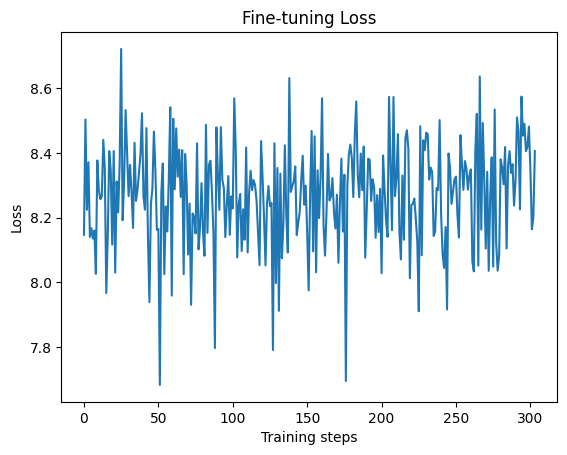

In [ ]:
# Plot training losses on x-axis
plt.plot(losses)
# print(losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.title("Fine-tuning Loss")
plt.show()


In [ ]:
def construct_test_samples(example):
    """
    Helper for converting input examples which have
    a separate question, labels, answer options
    into a single string for testing the model.

    Arguments
    ---------
    example: dict
        Sample input from the dataset which contains the
        question, answer labels (e.g. A, B, C, D),
        the answer options for the question, and which
        of the answers is correct.

    Returns
    -------
    input_text: str, str
        Tuple: Formatted test text which contains the question,
        the formatted answer options (e.g., 'A. <option 1> B. <option 2>' etc);
        the ground truth answer label only.
    """

    answer_options_list = list(zip(
        example["choices"]["label"],
        example["choices"]["text"]
    ))
    # Join each label and text with '. ' and space
    answer_options = " ".join([f"{label}. {text}" for label, text in answer_options_list])
    # Join the list of options with spaces into single string
    answer_options_string = " ".join(answer_options.split())
    # Combine question and answer options
    input_text = example["question"] + " " + answer_options_string
    # Create the test input text which should be:
    # the input text, followed by the string "Answer: "
    # We don't need to append the ground truth answer since we are creating test inputs
    # and the answer should be predicted.
    input_text += "\nAnswer: "

    return input_text, example["answerKey"]

# Construct test samples for the first 10 examples in the validation set
test_samples = [construct_test_samples(dataset["validation"][i]) for i in range(10)]
test_samples


[('A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? A. bank B. library C. department store D. mall E. new york\nAnswer: ',
  'A'),
 ('What do people aim to do at work? A. complete job B. learn from each other C. kill animals D. wear hats E. talk to each other\nAnswer: ',
  'A'),
 ('Where would you find magazines along side many other printed works? A. doctor B. bookstore C. market D. train station E. mortuary\nAnswer: ',
  'B'),
 ('Where are  you likely to find a hamburger? A. fast food restaurant B. pizza C. ground up dead cows D. mouth E. cow carcus\nAnswer: ',
  'A'),
 ('James was looking for a good place to buy farmland.  Where might he look? A. midwest B. countryside C. estate D. farming areas E. illinois\nAnswer: ',
  'A'),
 ('What island country is ferret popular? A. own home B. north carolina C. great britain D. hutch E. outdoors\nAnswer: ',
  'C'),
 ("In what Spanish speaking North American country can you get a great

In [ ]:
# Test the model

# set it to evaluation mode
model.eval()

predictions = []
for sample in test_samples:
    input_text = sample[0]
    input_ids = tokenizer(input_text, return_tensors="pt").to(device)
    output = model.generate(
        input_ids.input_ids,
        attention_mask = input_ids.attention_mask,
        max_new_tokens=2,
        do_sample=True,
        temperature=0.4,
    )
    prediction = tokenizer.decode(output[0], skip_special_tokens=True)
    predictions.append((input_text, prediction, sample[1]))

print("Predictions of trained model ", predictions)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predictions of trained model  [('A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? A. bank B. library C. department store D. mall E. new york\nAnswer: ', 'A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? A. bank B. library C. department store D. mall E. new york\nAnswer: \xa0The', 'A'), ('What do people aim to do at work? A. complete job B. learn from each other C. kill animals D. wear hats E. talk to each other\nAnswer: ', 'What do people aim to do at work? A. complete job B. learn from each other C. kill animals D. wear hats E. talk to each other\nAnswer: \xa0I', 'A'), ('Where would you find magazines along side many other printed works? A. doctor B. bookstore C. market D. train station E. mortuary\nAnswer: ', 'Where would you find magazines along side many other printed works? A. doctor B. bookstore C. market D. train station E. mortuary\nAnswer: \xa0I', 'B'), ('Whe